In [2]:
using DataDrivenDiffEq, ModelingToolkit, OrdinaryDiffEq, LinearAlgebra, Plots

┌ Info: Precompiling DataDrivenDiffEq [2445eb08-9709-466a-b3fc-47e12bd697a2]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [48]:
function pendulum(u, p, t)
    x, y = u
    dx = y
    dy = -9.81sin(x) - 0.1y
    return [dx; dy]
end

u0 = [0.4π; 1.0]
tspan = (0.0, 20.0)
problem = ODEProblem(pendulum, u0, tspan)
solution = solve(problem, Tsit5(), atol = 1e-8, rtol = 1e-8, saveat = 0.01)

X = Array(solution)
DX = solution(solution.t, Val{1}); # derivative of x & y, notice x'=y

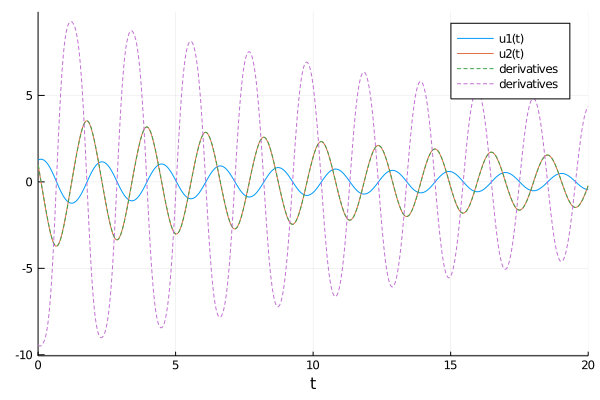

In [57]:
plot(solution)
plot!(DX, line=:dash, label="derivatives")

To apply SINDy, we need three ingredients:

* A Basis containing all possible candidate functions which might be in the model
* An optimizer which is able to produce a sparse output
* A threshold for the optimizer

In [58]:
@variables u[1:2]
h = Operation[u; u.^2; u.^3; sin.(u); cos.(u); 1] # candidates
basis = Basis(h, u)

11 dimensional basis in ["u₁", "u₂"]

In [64]:
opt = SR3() # a commonly used optimizere (https://ieeexplore.ieee.org/document/8573778)
Ψ = SINDy(X[:, 1:1000], DX[:, 1:1000], basis, opt, maxiter = 10000, normalize = true) # only part of data used for training

Sparse Identification Result with 4 active terms.

In [61]:
sys = ODESystem(Ψ)
p = parameters(Ψ)
dudt = ODEFunction(sys)
estimator = ODEProblem(dudt, u0, tspan, p)
estimation = solve(estimator, Tsit5(), saveat = solution.t)

retcode: Success
Interpolation: 1st order linear
t: 2001-element Array{Float64,1}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1
  0.11
  0.12
  ⋮
 19.89
 19.9
 19.91
 19.92
 19.93
 19.94
 19.95
 19.96
 19.97
 19.98
 19.99
 20.0
u: 2001-element Array{Array{Float64,1},1}:
 [1.2566370614359172, 1.0]
 [1.2665743138371237, 0.906046616664015]
 [1.275573169290745, 0.8118644727604934]
 [1.2836313728674746, 0.7174883050223232]
 [1.2907469917245957, 0.6229509834177686]
 [1.2969184151059818, 0.528283511150479]
 [1.302144354342097, 0.43351502465947356]
 [1.3064238427199426, 0.33867283352833877]
 [1.309756198770077, 0.24378416504517414]
 [1.312140947740116, 0.1488734891599645]
 [1.3135778540641165, 0.05396411910674024]
 [1.3140669291511404, -0.04092032032710584]
 [1.3136084313852532, -0.1357558928008147]
 ⋮
 [1.0810113762677667, 0.4605532246918205]
 [1.0855661492511317, 0.3736437953827572]
 [1.0892523722296534, 0.28659302265442216]
 [1.0920685827804628, 0.1994434039843

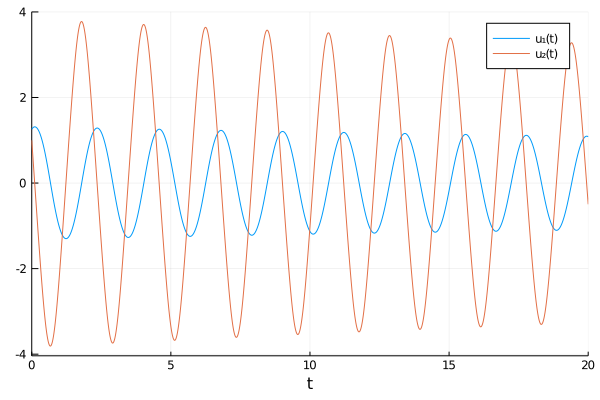

In [62]:
plot(estimation)

In [66]:
u

2-element Array{Operation,1}:
 u₁
 u₂